<a href="https://colab.research.google.com/github/leonardoub/SCRIPT_PALERMO/blob/master/classification/Classification_NO_kfold.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy
import seaborn as sns

In [2]:
# Seed value
# Apparently you may use different seed values at each stage
seed_value= 0

# 1. Set `PYTHONHASHSEED` environment variable at a fixed value
import os
os.environ['PYTHONHASHSEED']=str(seed_value)

# 2. Set `python` built-in pseudo-random generator at a fixed value
import random
random.seed(seed_value)

# 3. Set `numpy` pseudo-random generator at a fixed value
import numpy as np
np.random.seed(seed_value)

# 4. Set `tensorflow` pseudo-random generator at a fixed value
import tensorflow as tf
tf.set_random_seed(seed_value)

# 5. Configure a new global `tensorflow` session
from keras import backend as K
session_conf = tf.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
sess = tf.Session(graph=tf.get_default_graph(), config=session_conf)
K.set_session(sess)

Using TensorFlow backend.


#Load data

In [3]:
#load data from Drive
from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /gdrive
/gdrive


In [0]:
train_dataset_path = '/gdrive/My Drive/AIM_PA/database_training2.csv'
test_dataset_path = '/gdrive/My Drive/AIM_PA/database_nostro_without_nan.csv'

In [0]:
df_train = pd.read_csv(train_dataset_path)
df_test = pd.read_csv(test_dataset_path)

In [0]:
df_train.rename(columns={'Survival.time (months)':'Surv_time_months'}, inplace=True)

In [0]:
df_test.rename(columns={'Survival.time (months)':'Surv_time_months'}, inplace=True)

In [0]:
df_train.rename(columns={'Overall.Stage':'Overall_Stage'}, inplace=True)
df_test.rename(columns={'Overall.Stage':'Overall_Stage'}, inplace=True)

In [0]:
public_data = df_train.drop(['Histology', 'Surv_time_months', 'OS', 'deadstatus.event','Overall_Stage'], axis=1)

In [0]:
PA_data = df_test.drop(['Histology', 'Surv_time_months', 'OS', 'deadstatus.event','Overall_Stage'], axis=1)

In [0]:
public_labels = df_train.Histology

In [0]:
PA_labels = df_test.Histology

#Train Test Split

In [0]:
from sklearn.model_selection import train_test_split

In [0]:
X_train_big, X_test, y_train_big, y_test = train_test_split(public_data, public_labels, test_size=13, stratify=public_labels, random_state=1)

#Train Validation Split

In [0]:
from sklearn.model_selection import train_test_split

In [0]:
X_train, X_val, y_train, y_val = train_test_split(X_train_big, y_train_big, test_size=13, stratify=y_train_big, random_state=2)                                                         

#Z score dei dati

In [0]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
train_data_stand = scaler.fit_transform(X_train)
val_data_stand = scaler.transform(X_val)
test_data_stand = scaler.transform(X_test)

#LDA

In [0]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

In [0]:
lda = LinearDiscriminantAnalysis(n_components=3)

In [20]:
train_data_stand_lda = lda.fit(train_data_stand, y_train).transform(train_data_stand)

/usr/local/lib/python3.6/dist-packages/sklearn/discriminant_analysis.py:463: ChangedBehaviorWarning: n_components cannot be larger than min(n_features, n_classes - 1). Using min(n_features, n_classes - 1) = min(107, 3 - 1) = 2 components.
  ChangedBehaviorWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/discriminant_analysis.py:469: FutureWarning: In version 0.23, setting n_components > min(n_features, n_classes - 1) will raise a ValueError. You should set n_components to None (default), or a value smaller or equal to min(n_features, n_classes - 1).
  warnings.warn(future_msg, FutureWarning)


In [21]:
train_data_stand_lda.shape

(105, 2)

In [0]:
val_data_stand_lda = lda.transform(val_data_stand)

In [0]:
test_data_stand_lda = lda.transform(test_data_stand)

##Z-score dopo LDA

In [0]:
from sklearn.preprocessing import StandardScaler
scaler_2 = StandardScaler()
train_data_stand_lda = scaler_2.fit_transform(train_data_stand_lda)
val_data_stand_lda = scaler_2.transform(val_data_stand_lda)
test_data_stand_lda = scaler_2.transform(test_data_stand_lda)

In [0]:
mean = train_data_stand_lda.mean(axis=0)
std = train_data_stand_lda.std(axis=0)
train_data_stand_lda = train_data_stand_lda - mean
train_data_stand_lda /= std

In [0]:
val_data_stand_lda = val_data_stand_lda - mean
val_data_stand_lda /= std

In [0]:
test_data_stand_lda = test_data_stand_lda - mean
test_data_stand_lda /= std

##Vettorizzare i label

In [0]:
word_index={'adenocarcinoma':0, 'large cell':1, 'squamous cell carcinoma':2}

In [0]:
train_labels_dec = [word_index[label] for label in y_train]

In [0]:
val_labels_dec = [word_index[label] for label in y_val]

In [0]:
test_labels_dec = [word_index[label] for label in y_test]

In [0]:
from keras.utils.np_utils import to_categorical

In [0]:
one_hot_train_labels = to_categorical(train_labels_dec)
one_hot_val_labels = to_categorical(val_labels_dec)
one_hot_test_labels = to_categorical(test_labels_dec)

#Building Network

In [0]:
import keras
from keras import layers
from keras.preprocessing import sequence

In [0]:
from keras import layers

In [0]:
from keras import regularizers

In [0]:
from keras.optimizers import SGD

In [0]:
def build_model():
  model = keras.models.Sequential()
  model.add(layers.Dense(8, activation='relu', input_shape=(2,), kernel_regularizer=regularizers.l2(l=0.1)))
  model.add(layers.Dense(7, activation='relu'))
  #model.add(layers.Dropout(rate=0.2))

  model.add(layers.Dense(3, activation='softmax'))

  sgd = SGD(lr=0.001, momentum=0.9)
  
  model.compile(optimizer=sgd, loss='categorical_crossentropy', metrics=['accuracy'])
  return model

In [0]:
from keras.callbacks import ReduceLROnPlateau
red_lr = ReduceLROnPlateau('val_loss', patience=10, verbose=1, min_lr=0.0001)

In [54]:
one_hot_val_labels.shape

(13, 3)

In [55]:
num_epochs = 500

model = build_model()
history = model.fit(train_data_stand_lda, one_hot_train_labels, validation_data=(val_data_stand_lda, one_hot_val_labels), 
                      epochs= num_epochs, batch_size=105, callbacks=[red_lr])
  

acc_history = history.history['acc']
loss_history = history.history['loss']
acc_val_history = history.history['val_acc']
loss_val_history = history.history['val_loss']


Train on 105 samples, validate on 13 samples
Epoch 1/500
105/105 [==============================] - 0s 2ms/step - loss: 1.3727 - acc: 0.9810 - val_loss: 1.4264 - val_acc: 0.3846
Epoch 2/500
105/105 [==============================] - 0s 24us/step - loss: 1.3723 - acc: 0.9810 - val_loss: 1.4260 - val_acc: 0.3846
Epoch 3/500
105/105 [==============================] - 0s 33us/step - loss: 1.3716 - acc: 0.9810 - val_loss: 1.4255 - val_acc: 0.3846
Epoch 4/500
105/105 [==============================] - 0s 28us/step - loss: 1.3707 - acc: 0.9810 - val_loss: 1.4249 - val_acc: 0.3846
Epoch 5/500
105/105 [==============================] - 0s 24us/step - loss: 1.3695 - acc: 0.9810 - val_loss: 1.4241 - val_acc: 0.3846
Epoch 6/500
105/105 [==============================] - 0s 24us/step - loss: 1.3680 - acc: 0.9810 - val_loss: 1.4233 - val_acc: 0.3846
Epoch 7/500
105/105 [==============================] - 0s 22us/step - loss: 1.3664 - acc: 0.9810 - val_loss: 1.4223 - val_acc: 0.3077
Epoch 8/500
105/10

##Plotting training and validation loss

In [0]:
import matplotlib.pyplot as plt

In [0]:
epochs = range(1, num_epochs+1)

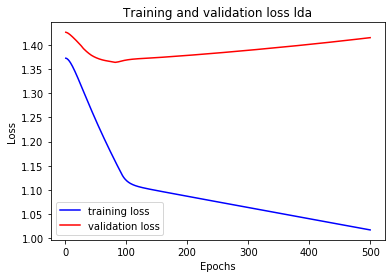

In [56]:
plt.plot(epochs, loss_history, 'b', label='training loss')
plt.plot(epochs, loss_val_history, 'r', label='validation loss')
plt.title('Training and validation loss lda')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

##Plotting train and validation accuracy

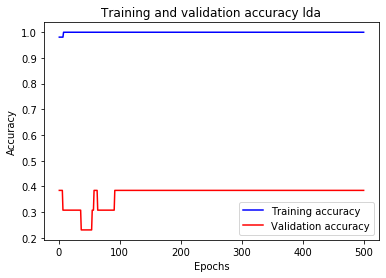

In [57]:
plt.plot(epochs, acc_history, 'b', label='Training accuracy')
plt.plot(epochs, acc_val_history, 'r', label='Validation accuracy')
plt.title('Training and validation accuracy lda')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend() 

##Performances on test set

In [0]:
 model = build_model()
 model.fit(train_data_stand_lda, one_hot_train_labels, epochs= num_epochs, batch_size=1, shuffle=True)
 test_loss, test_acc = model.evaluate(test_data_stand_lda, one_hot_test_labels)
  

Epoch 1/180
105/105 [==============================] - 0s 4ms/step - loss: 1.1976 - acc: 0.4476
Epoch 2/180
105/105 [==============================] - 0s 895us/step - loss: 1.0908 - acc: 0.5810
Epoch 3/180
105/105 [==============================] - 0s 915us/step - loss: 1.0153 - acc: 0.5810
Epoch 4/180
105/105 [==============================] - 0s 917us/step - loss: 0.9541 - acc: 0.5905
Epoch 5/180
105/105 [==============================] - 0s 787us/step - loss: 0.9022 - acc: 0.7714
Epoch 6/180
105/105 [==============================] - 0s 799us/step - loss: 0.8565 - acc: 0.9810
Epoch 7/180
105/105 [==============================] - 0s 939us/step - loss: 0.8157 - acc: 0.9905
Epoch 8/180
105/105 [==============================] - 0s 852us/step - loss: 0.7787 - acc: 0.9905
Epoch 9/180
105/105 [==============================] - 0s 817us/step - loss: 0.7448 - acc: 1.0000
Epoch 10/180
105/105 [==============================] - 0s 809us/step - loss: 0.7135 - acc: 1.0000
Epoch 11/180
105/105 

In [0]:
model.metrics_names

['loss', 'acc']

In [0]:
test_acc


0.4615384638309479

Si comporta molto bene in training e in validation ma si comporta male in test

#PCA

#NO FEATURES SELECTION

Remove correlated features manually